In [42]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [43]:
data = pd.read_csv('.\data1mins.csv')

In [44]:
data

Loading ITables v2.5.2 from the internet... (need help?)


In [45]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

In [46]:
from scipy import signal
from scipy.signal import butter,lfilter 

def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [47]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2219, 6, 17),
 datetime.date(2029, 6, 21),
 datetime.date(2052, 4, 18),
 datetime.date(2111, 6, 18),
 datetime.date(2025, 2, 20),
 datetime.date(2046, 2, 15),
 datetime.date(2198, 11, 15),
 datetime.date(2032, 10, 21),
 datetime.date(2090, 1, 19),
 datetime.date(2078, 6, 16),
 datetime.date(2061, 2, 17),
 datetime.date(2066, 8, 19),
 datetime.date(2053, 5, 15),
 datetime.date(2058, 3, 21),
 datetime.date(2185, 6, 16),
 datetime.date(2229, 12, 17),
 datetime.date(2076, 12, 17),
 datetime.date(2116, 7, 16),
 datetime.date(2178, 9, 17),
 datetime.date(2096, 10, 18),
 datetime.date(2045, 4, 20),
 datetime.date(2161, 4, 16),
 datetime.date(2055, 4, 15),
 datetime.date(2023, 11, 16),
 datetime.date(2113, 10, 19),
 datetime.date(2123, 8, 19),
 datetime.date(2024, 6, 20),
 datetime.date(2199, 6, 20),
 datetime.date(2121, 11, 20),
 datetime.date(2028, 5, 18),
 datetime.date(2118, 2, 17),
 datetime.date(2106, 2, 18),
 datetime.date(2251, 9, 18),
 datetime.date(2152, 11, 16),
 date

In [86]:
def alpha(data, params):
    # copy & chỉ báo cơ bản
    data = data.copy()
    data['Close_filtered'] = lowpass_filter_period_only(data['Close'], params['t1'])
    data['RSI'] = RSIIndicator(close=data['Close'], window=params['w1']).rsi()
    data['RSI_MA'] = data['RSI'].rolling(params['w1']).mean()
    # FIX: df -> data
    data['SMA_short'] = SMAIndicator(close=data['Close'], window=params['sma_short']).sma_indicator()
    data['SMA_long']  = SMAIndicator(close=data['Close'], window=params['sma_long']).sma_indicator()

    # Khởi tạo
    pos = 0
    position = []
    poly_window = int(params.get('w2', 20))           # FIX: default & int
    consec_increases = int(params.get('consec_increases', 2))
    min_RSI = 999

    for i in range(len(data)):
        RSI = data['RSI'].iloc[i]
        if RSI < min_RSI:
            min_RSI = RSI

        # --------------------- TÍNH SLOPE/CURVATURE (đã sửa) ---------------------
        # Khởi tạo mặc định để tránh UnboundLocalError (giữ 0 theo flow của bạn)
        curvature = 0.0
        slope     = 0.0
        slope_1   = 0.0
        slope_short = 0.0
        slope_long  = 0.0
        slope_RSI   = 0.0

        if i >= poly_window - 1:
            # === dùng cửa sổ [i-poly_window+1 : i] ===
            y = data['Close'].iloc[i - poly_window + 1 : i + 1].values
            x = np.arange(len(y), dtype=float)

            # FIX: bậc 2 cần >=3 điểm & guard NaN
            if len(y) >= 3 and np.isfinite(y).all():
                coeffs = np.polyfit(x, y, 2)
                curvature = coeffs[0]
                slope     = coeffs[1]

            # FIX: bậc 1 cần >=2 điểm & guard NaN
            if len(y) >= 2 and np.isfinite(y).all():
                coeffs_1 = np.polyfit(x, y, 1)
                slope_1  = coeffs_1[0]

            # SMA_short slope
            y = data['SMA_short'].iloc[i - poly_window + 1 : i + 1].values
            x = np.arange(len(y), dtype=float)
            if len(y) >= 2 and np.isfinite(y).all():
                coeffs_short = np.polyfit(x, y, 1)
                slope_short  = coeffs_short[0]

            # SMA_long slope
            y = data['SMA_long'].iloc[i - poly_window + 1 : i + 1].values
            x = np.arange(len(y), dtype=float)
            if len(y) >= 2 and np.isfinite(y).all():
                coeffs_long = np.polyfit(x, y, 1)
                slope_long  = coeffs_long[0]

            # RSI slope
            y = data['RSI'].iloc[i - poly_window + 1 : i + 1].values
            x = np.arange(len(y), dtype=float)
            if len(y) >= 2 and np.isfinite(y).all():
                coeffs_RSI = np.polyfit(x, y, 1)
                slope_RSI  = coeffs_RSI[0]

        else:
            # === dùng toàn bộ [0 : i] (không để chỉ số âm) ===
            y = data['Close'].iloc[:i+1].values
            x = np.arange(len(y), dtype=float)

            # FIX: bậc 2 cần >=3
            if len(y) >= 3 and np.isfinite(y).all():
                coeffs = np.polyfit(x, y, 2)
                curvature = coeffs[0]
                slope     = coeffs[1]

            # FIX: bậc 1 cần >=2
            if len(y) >= 2 and np.isfinite(y).all():
                coeffs_1 = np.polyfit(x, y, 1)
                slope_1  = coeffs_1[0]

            # FIX: các slope của SMA/RSI ở nhánh else phải dùng [:i+1], không được dùng (i - poly_window + 1)
            y = data['SMA_short'].iloc[:i+1].values
            if len(y) >= 2 and np.isfinite(y).all():
                x = np.arange(len(y), dtype=float)
                slope_short = np.polyfit(x, y, 1)[0]

            y = data['SMA_long'].iloc[:i+1].values
            if len(y) >= 2 and np.isfinite(y).all():
                x = np.arange(len(y), dtype=float)
                slope_long = np.polyfit(x, y, 1)[0]

            y = data['RSI'].iloc[:i+1].values
            if len(y) >= 2 and np.isfinite(y).all():
                x = np.arange(len(y), dtype=float)
                slope_RSI = np.polyfit(x, y, 1)[0]
        # ------------------------------------------------------------------------

        # Thêm cơ chế xác nhận entry (giữ nguyên flow)
        entry_confirmed = False
        if i >= consec_increases - 1:
            entry_confirmed = True
            for k in range(1, consec_increases + 1):
                if data['Close'].iloc[i - k + 1] <= data['Close'].iloc[i - k]:
                    entry_confirmed = False
                    break

        # Logic vị thế (giữ nguyên flow)
        if pos == 0:
            # if RSI > params['t2'] and slope_1 > params['t4'] and entry_confirmed and curvature > params['t5']:
            #     pos = 1
            if RSI > min_RSI and slope_short > 0 and entry_confirmed:
                pos = 1
            
        else:
            if RSI < params['t3'] and (curvature < params['t5'] and slope_1 < 0):
                pos = 0

        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0

        position.append(pos)

    data['pos'] = position
    return data


In [87]:
params = {'t1': 0.75, 't2': 30, 't3': 50, 't4': 0, 't5': 0, 'w1': 10, 'w2': 10, 'consec_increases':3,'sma_long': 26, 'sma_short': 9}

In [88]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 9.56
MDD: 102.9 (6.53%)

   Total trading quantity: 835
         Profit per trade: 1.69
             Total Profit: 1770.2
         Profit after fee: 1409.4
 Trading quantity per day: 0.44
 Profit per day after fee: 0.74
                   Return: 0.12
          Profit per year: 184.98
                  HitRate: 0.43
          HitRate per day: 0.31


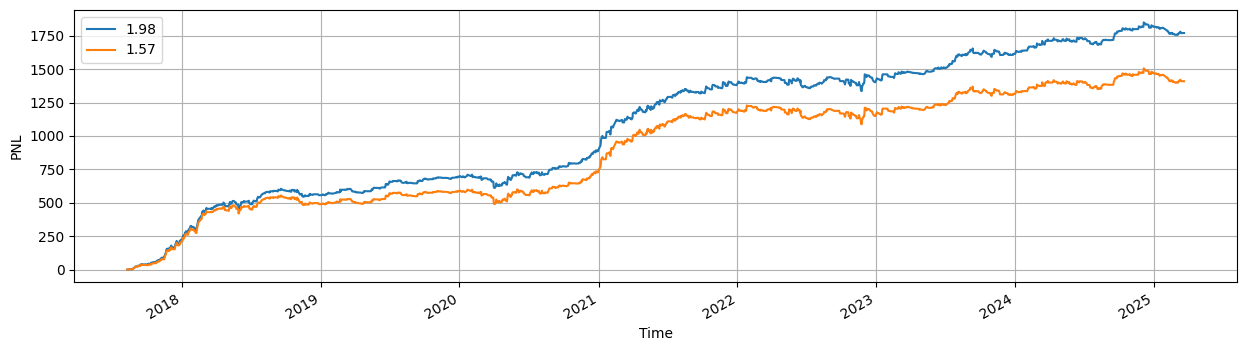

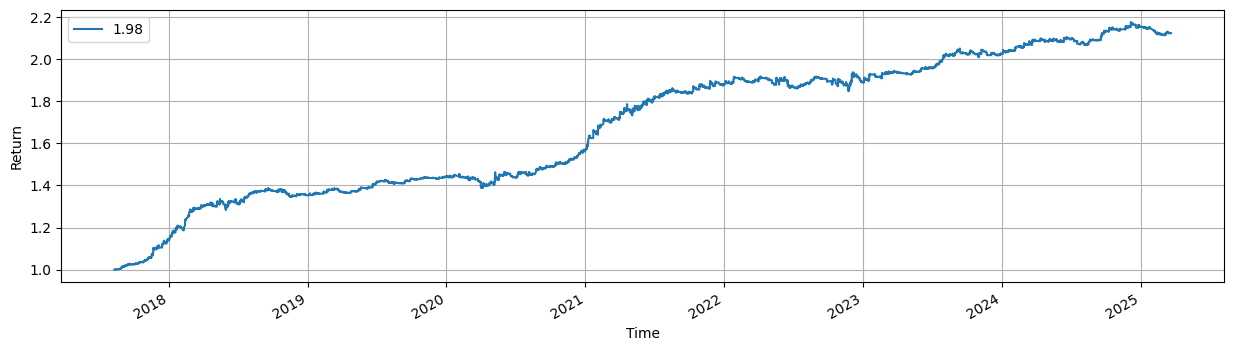

In [89]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [90]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [61]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)


In [62]:
merged = pd.merge(ds, pnl, left_on="Date",right_on= "Datetime", how="inner")
merged

Loading ITables v2.5.2 from the internet... (need help?)


In [55]:
df = pd.DataFrame(ds)

# select Date and pos
df_result = df[["Date", "Close", "pos"]]
df_result.to_csv("alpha_rsi_long.csv", index=False)